<a href="https://colab.research.google.com/github/deepshikharbhardwaj/Character-Region-Awareness-for-Text/blob/main/Finetune_CRAFT_M20MA004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.init as init
from torchvision import models
from torchvision.models.vgg import model_urls

def init_weights(modules):
    for m in modules:
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

class vgg16_bn(torch.nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(vgg16_bn, self).__init__()
        model_urls['vgg16_bn'] = model_urls['vgg16_bn'].replace('https://', 'http://')
        vgg_pretrained_features = models.vgg16_bn(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(12):         # conv2_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 19):         # conv3_3
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(19, 29):         # conv4_3
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(29, 39):         # conv5_3
            self.slice4.add_module(str(x), vgg_pretrained_features[x])

        # fc6, fc7 without atrous conv
        self.slice5 = torch.nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
                nn.Conv2d(1024, 1024, kernel_size=1)
        )

        if not pretrained:
            init_weights(self.slice1.modules())
            init_weights(self.slice2.modules())
            init_weights(self.slice3.modules())
            init_weights(self.slice4.modules())

        init_weights(self.slice5.modules())        # no pretrained model for fc6 and fc7

        if freeze:
            for param in self.slice1.parameters():      # only first conv
                param.requires_grad= False

    def forward(self, X):
        h = self.slice1(X)
        h_relu2_2 = h
        h = self.slice2(h)
        h_relu3_2 = h
        h = self.slice3(h)
        h_relu4_3 = h
        h = self.slice4(h)
        h_relu5_3 = h
        h = self.slice5(h)
        h_fc7 = h
        vgg_outputs = namedtuple("VggOutputs", ['fc7', 'relu5_3', 'relu4_3', 'relu3_2', 'relu2_2'])
        out = vgg_outputs(h_fc7, h_relu5_3, h_relu4_3, h_relu3_2, h_relu2_2)
        return out

In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F

#from basenet.vgg16_bn import vgg16_bn, init_weights

class double_conv(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch + mid_ch, mid_ch, kernel_size=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class CRAFT(nn.Module):
    def __init__(self, pretrained=False, freeze=False):
        super(CRAFT, self).__init__()

        """ Base network """
        self.basenet = vgg16_bn(pretrained, freeze)

        """ U network """
        self.upconv1 = double_conv(1024, 512, 256)
        self.upconv2 = double_conv(512, 256, 128)
        self.upconv3 = double_conv(256, 128, 64)
        self.upconv4 = double_conv(128, 64, 32)

        num_class = 2
        self.conv_cls = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, num_class, kernel_size=1),
        )

        init_weights(self.upconv1.modules())
        init_weights(self.upconv2.modules())
        init_weights(self.upconv3.modules())
        init_weights(self.upconv4.modules())
        init_weights(self.conv_cls.modules())
        
    def forward(self, x):
        """ Base network """
        sources = self.basenet(x)

        """ U network """
        y = torch.cat([sources[0], sources[1]], dim=1)
        y = self.upconv1(y)

        y = F.interpolate(y, size=sources[2].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[2]], dim=1)
        y = self.upconv2(y)

        y = F.interpolate(y, size=sources[3].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[3]], dim=1)
        y = self.upconv3(y)

        y = F.interpolate(y, size=sources[4].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[4]], dim=1)
        feature = self.upconv4(y)

        y = self.conv_cls(feature)

        return y.permute(0,2,3,1), feature

if __name__ == '__main__':
    model = CRAFT(pretrained=True).cuda()
    output, _ = model(torch.randn(1, 3, 768, 768).cuda())
    print(output.shape)

torch.Size([1, 384, 384, 2])


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import cv2
import math

""" auxilary functions """
# unwarp corodinates
def warpCoord(Minv, pt):
    out = np.matmul(Minv, (pt[0], pt[1], 1))
    return np.array([out[0]/out[2], out[1]/out[2]])
""" end of auxilary functions """


def getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text):
    # prepare data
    linkmap = linkmap.copy()
    textmap = textmap.copy()
    img_h, img_w = textmap.shape

    """ labeling method """
    ret, text_score = cv2.threshold(textmap, low_text, 1, 0)
    ret, link_score = cv2.threshold(linkmap, link_threshold, 1, 0)

    text_score_comb = np.clip(text_score + link_score, 0, 1)
    nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(text_score_comb.astype(np.uint8), connectivity=4)

    det = []
    mapper = []
    for k in range(1,nLabels):
        # size filtering
        size = stats[k, cv2.CC_STAT_AREA]
        if size < 10: continue

        # thresholding
        if np.max(textmap[labels==k]) < text_threshold: continue

        # make segmentation map
        segmap = np.zeros(textmap.shape, dtype=np.uint8)
        segmap[labels==k] = 255
        segmap[np.logical_and(link_score==1, text_score==0)] = 0   # remove link area
        x, y = stats[k, cv2.CC_STAT_LEFT], stats[k, cv2.CC_STAT_TOP]
        w, h = stats[k, cv2.CC_STAT_WIDTH], stats[k, cv2.CC_STAT_HEIGHT]
        niter = int(math.sqrt(size * min(w, h) / (w * h)) * 2)
        sx, ex, sy, ey = x - niter, x + w + niter + 1, y - niter, y + h + niter + 1
        # boundary check
        if sx < 0 : sx = 0
        if sy < 0 : sy = 0
        if ex >= img_w: ex = img_w
        if ey >= img_h: ey = img_h
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1 + niter, 1 + niter))
        segmap[sy:ey, sx:ex] = cv2.dilate(segmap[sy:ey, sx:ex], kernel)

        # make box
        np_contours = np.roll(np.array(np.where(segmap!=0)),1,axis=0).transpose().reshape(-1,2)
        rectangle = cv2.minAreaRect(np_contours)
        box = cv2.boxPoints(rectangle)

        # align diamond-shape
        w, h = np.linalg.norm(box[0] - box[1]), np.linalg.norm(box[1] - box[2])
        box_ratio = max(w, h) / (min(w, h) + 1e-5)
        if abs(1 - box_ratio) <= 0.1:
            l, r = min(np_contours[:,0]), max(np_contours[:,0])
            t, b = min(np_contours[:,1]), max(np_contours[:,1])
            box = np.array([[l, t], [r, t], [r, b], [l, b]], dtype=np.float32)

        # make clock-wise order
        startidx = box.sum(axis=1).argmin()
        box = np.roll(box, 4-startidx, 0)
        box = np.array(box)

        det.append(box)
        mapper.append(k)

    return det, labels, mapper

def getPoly_core(boxes, labels, mapper, linkmap):
    # configs
    num_cp = 5
    max_len_ratio = 0.7
    expand_ratio = 1.45
    max_r = 2.0
    step_r = 0.2

    polys = []  
    for k, box in enumerate(boxes):
        # size filter for small instance
        w, h = int(np.linalg.norm(box[0] - box[1]) + 1), int(np.linalg.norm(box[1] - box[2]) + 1)
        if w < 10 or h < 10:
            polys.append(None); continue

        # warp image
        tar = np.float32([[0,0],[w,0],[w,h],[0,h]])
        M = cv2.getPerspectiveTransform(box, tar)
        word_label = cv2.warpPerspective(labels, M, (w, h), flags=cv2.INTER_NEAREST)
        try:
            Minv = np.linalg.inv(M)
        except:
            polys.append(None); continue

        # binarization for selected label
        cur_label = mapper[k]
        word_label[word_label != cur_label] = 0
        word_label[word_label > 0] = 1

        """ Polygon generation """
        # find top/bottom contours
        cp = []
        max_len = -1
        for i in range(w):
            region = np.where(word_label[:,i] != 0)[0]
            if len(region) < 2 : continue
            cp.append((i, region[0], region[-1]))
            length = region[-1] - region[0] + 1
            if length > max_len: max_len = length

        # pass if max_len is similar to h
        if h * max_len_ratio < max_len:
            polys.append(None); continue

        # get pivot points with fixed length
        tot_seg = num_cp * 2 + 1
        seg_w = w / tot_seg     # segment width
        pp = [None] * num_cp    # init pivot points
        cp_section = [[0, 0]] * tot_seg
        seg_height = [0] * num_cp
        seg_num = 0
        num_sec = 0
        prev_h = -1
        for i in range(0,len(cp)):
            (x, sy, ey) = cp[i]
            if (seg_num + 1) * seg_w <= x and seg_num <= tot_seg:
                # average previous segment
                if num_sec == 0: break
                cp_section[seg_num] = [cp_section[seg_num][0] / num_sec, cp_section[seg_num][1] / num_sec]
                num_sec = 0

                # reset variables
                seg_num += 1
                prev_h = -1

            # accumulate center points
            cy = (sy + ey) * 0.5
            cur_h = ey - sy + 1
            cp_section[seg_num] = [cp_section[seg_num][0] + x, cp_section[seg_num][1] + cy]
            num_sec += 1

            if seg_num % 2 == 0: continue # No polygon area

            if prev_h < cur_h:
                pp[int((seg_num - 1)/2)] = (x, cy)
                seg_height[int((seg_num - 1)/2)] = cur_h
                prev_h = cur_h

        # processing last segment
        if num_sec != 0:
            cp_section[-1] = [cp_section[-1][0] / num_sec, cp_section[-1][1] / num_sec]

        # pass if num of pivots is not sufficient or segment widh is smaller than character height 
        if None in pp or seg_w < np.max(seg_height) * 0.25:
            polys.append(None); continue

        # calc median maximum of pivot points
        half_char_h = np.median(seg_height) * expand_ratio / 2

        # calc gradiant and apply to make horizontal pivots
        new_pp = []
        for i, (x, cy) in enumerate(pp):
            dx = cp_section[i * 2 + 2][0] - cp_section[i * 2][0]
            dy = cp_section[i * 2 + 2][1] - cp_section[i * 2][1]
            if dx == 0:     # gradient if zero
                new_pp.append([x, cy - half_char_h, x, cy + half_char_h])
                continue
            rad = - math.atan2(dy, dx)
            c, s = half_char_h * math.cos(rad), half_char_h * math.sin(rad)
            new_pp.append([x - s, cy - c, x + s, cy + c])

        # get edge points to cover character heatmaps
        isSppFound, isEppFound = False, False
        grad_s = (pp[1][1] - pp[0][1]) / (pp[1][0] - pp[0][0]) + (pp[2][1] - pp[1][1]) / (pp[2][0] - pp[1][0])
        grad_e = (pp[-2][1] - pp[-1][1]) / (pp[-2][0] - pp[-1][0]) + (pp[-3][1] - pp[-2][1]) / (pp[-3][0] - pp[-2][0])
        for r in np.arange(0.5, max_r, step_r):
            dx = 2 * half_char_h * r
            if not isSppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_s * dx
                p = np.array(new_pp[0]) - np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    spp = p
                    isSppFound = True
            if not isEppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_e * dx
                p = np.array(new_pp[-1]) + np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    epp = p
                    isEppFound = True
            if isSppFound and isEppFound:
                break

        # pass if boundary of polygon is not found
        if not (isSppFound and isEppFound):
            polys.append(None); continue

        # make final polygon
        poly = []
        poly.append(warpCoord(Minv, (spp[0], spp[1])))
        for p in new_pp:
            poly.append(warpCoord(Minv, (p[0], p[1])))
        poly.append(warpCoord(Minv, (epp[0], epp[1])))
        poly.append(warpCoord(Minv, (epp[2], epp[3])))
        for p in reversed(new_pp):
            poly.append(warpCoord(Minv, (p[2], p[3])))
        poly.append(warpCoord(Minv, (spp[2], spp[3])))

        # add to final result
        polys.append(np.array(poly))

    return polys

def getDetBoxes(textmap, linkmap, text_threshold, link_threshold, low_text, poly=False):
    boxes, labels, mapper = getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text)

    if poly:
        polys = getPoly_core(boxes, labels, mapper, linkmap)
    else:
        polys = [None] * len(boxes)

    return boxes, polys

def adjustResultCoordinates(polys, ratio_w, ratio_h, ratio_net = 2):
    if len(polys) > 0:
        polys = np.array(polys)
        for k in range(len(polys)):
            if polys[k] is not None:
                polys[k] *= (ratio_w * ratio_net, ratio_h * ratio_net)
    return polys

In [ ]:
import scipy.misc, numpy as np, os, sys
import imageio
from PIL import Image

def save_img(out_path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    imageio.imwrite(out_path, img)

def scale_img(style_path, style_scale):
    scale = float(style_scale)
    o0, o1, o2 = imageio.imread(style_path, pilmode='RGB').shape
    scale = float(style_scale)
    new_shape = (int(o0 * scale), int(o1 * scale), o2)
    style_target = _get_img(style_path, img_size=new_shape)
    return style_target

def get_img(src, img_size=False):
   img = imageio.imread(src, pilmode='RGB') # misc.imresize(, (256, 256, 3))
   if not (len(img.shape) == 3 and img.shape[2] == 3):
       img = np.dstack((img,img,img))
   if img_size != False:
       img = np.array(Image.fromarray(img).resize(img_size[:2]))
   return img

def exists(p, msg):
    assert os.path.exists(p), msg

def list_files(in_path):
    files = []
    for (dirpath, dirnames, filenames) in os.walk(in_path):
        files.extend(filenames)
        break

    return files

In [ ]:
import numpy as np
from skimage import io
import cv2

def loadImage(img_file):
    img = io.imread(img_file)           # RGB order
    if img.shape[0] == 2: img = img[0]
    if len(img.shape) == 2 : img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[2] == 4:   img = img[:,:,:3]
    img = np.array(img)

    return img

def normalizeMeanVariance(in_img, mean=(0.485, 0.456, 0.406), variance=(0.229, 0.224, 0.225)):
    # should be RGB order
    img = in_img.copy().astype(np.float32)

    img -= np.array([mean[0] * 255.0, mean[1] * 255.0, mean[2] * 255.0], dtype=np.float32)
    img /= np.array([variance[0] * 255.0, variance[1] * 255.0, variance[2] * 255.0], dtype=np.float32)
    return img

def denormalizeMeanVariance(in_img, mean=(0.485, 0.456, 0.406), variance=(0.229, 0.224, 0.225)):
    # should be RGB order
    img = in_img.copy()
    img *= variance
    img += mean
    img *= 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def resize_aspect_ratio(img, square_size, interpolation, mag_ratio=1):
    height, width, channel = img.shape

    # magnify image size
    target_size = mag_ratio * max(height, width)

    # set original image size
    if target_size > square_size:
        target_size = square_size
    
    ratio = target_size / max(height, width)    

    target_h, target_w = int(height * ratio), int(width * ratio)
    proc = cv2.resize(img, (target_w, target_h), interpolation = interpolation)


    # make canvas and paste image
    target_h32, target_w32 = target_h, target_w
    if target_h % 32 != 0:
        target_h32 = target_h + (32 - target_h % 32)
    if target_w % 32 != 0:
        target_w32 = target_w + (32 - target_w % 32)
    resized = np.zeros((target_h32, target_w32, channel), dtype=np.float32)
    resized[0:target_h, 0:target_w, :] = proc
    target_h, target_w = target_h32, target_w32

    size_heatmap = (int(target_w/2), int(target_h/2))

    return resized, ratio, size_heatmap

def cvt2HeatmapImg(img):
    img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    return img

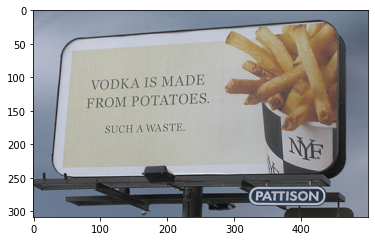

In [ ]:
#!pip install imgproc
import os
import numpy as np
import cv2
#import imgproc
import matplotlib
import matplotlib.pylab as plt

from os.path import exists, join, basename, splitext
IMAGE_URL = 'https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/billboard.jpg'
#https://github.com/deepshikharbhardwaj/Speach-to-text/blob/main/stt.png?raw=true
#https://raw.githubusercontent.com/deepshikharbhardwaj/Speach-to-text/main/stt.png
#IMAGE_URL = 'https://raw.githubusercontent.com/deepshikharbhardwaj/Speach-to-text/main/stt.png'

image_file_name = basename(IMAGE_URL)
download_dir = '/content/images'
!mkdir -p {download_dir} && rm -rf {download_dir}/*
!wget -q -P {download_dir} {IMAGE_URL}
  

plt.imshow(matplotlib.image.imread(join(download_dir, image_file_name)))

# borrowed from https://github.com/lengstrom/fast-style-transfer/blob/master/src/utils.py
def get_files(img_dir):
    imgs, masks, xmls = list_files(img_dir)
    return imgs, masks, xmls

def list_files(in_path):
    img_files = []
    mask_files = []
    gt_files = []
    for (dirpath, dirnames, filenames) in os.walk(in_path):
        for file in filenames:
            filename, ext = os.path.splitext(file)
            ext = str.lower(ext)
            if ext == '.jpg' or ext == '.jpeg' or ext == '.gif' or ext == '.png' or ext == '.pgm':
                img_files.append(os.path.join(dirpath, file))
            elif ext == '.bmp':
                mask_files.append(os.path.join(dirpath, file))
            elif ext == '.xml' or ext == '.gt' or ext == '.txt':
                gt_files.append(os.path.join(dirpath, file))
            elif ext == '.zip':
                continue
    # img_files.sort()
    # mask_files.sort()
    # gt_files.sort()
    return img_files, mask_files, gt_files

def saveResult(img_file, img, boxes, dirname='/content/result', verticals=None, texts=None):
        """ save text detection result one by one
        Args:
            img_file (str): image file name
            img (array): raw image context
            boxes (array): array of result file
                Shape: [num_detections, 4] for BB output / [num_detections, 4] for QUAD output
        Return:
            None
        """
        img = np.array(img)

        # make result file list
        filename, file_ext = os.path.splitext(os.path.basename(img_file))

        # result directory
        res_file = dirname + "res_" + filename + '.txt'
        res_img_file = dirname + "res_" + filename + '.jpg'

        if not os.path.isdir(dirname):
            os.mkdir(dirname)

        with open(res_file, 'w') as f:
            for i, box in enumerate(boxes):
                poly = np.array(box).astype(np.int32).reshape((-1))
                strResult = ','.join([str(p) for p in poly]) + '\r\n'
                f.write(strResult)

                poly = poly.reshape(-1, 2)
                cv2.polylines(img, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)
                ptColor = (0, 255, 255)
                if verticals is not None:
                    if verticals[i]:
                        ptColor = (255, 0, 0)

                if texts is not None:
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    font_scale = 0.5
                    cv2.putText(img, "{}".format(texts[i]), (poly[0][0]+1, poly[0][1]+1), font, font_scale, (0, 0, 0), thickness=1)
                    cv2.putText(img, "{}".format(texts[i]), tuple(poly[0]), font, font_scale, (0, 255, 255), thickness=1)

        # Save result image
        cv2.imwrite(res_img_file, img)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#from basenet.vgg16_bn import init_weights


class RefineNet(nn.Module):
    def __init__(self):
        super(RefineNet, self).__init__()

        self.last_conv = nn.Sequential(
            nn.Conv2d(34, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True)
        )

        self.aspp1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, dilation=6, padding=6), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1)
        )

        self.aspp2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, dilation=12, padding=12), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1)
        )

        self.aspp3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, dilation=18, padding=18), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1)
        )

        self.aspp4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, dilation=24, padding=24), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1)
        )

        init_weights(self.last_conv.modules())
        init_weights(self.aspp1.modules())
        init_weights(self.aspp2.modules())
        init_weights(self.aspp3.modules())
        init_weights(self.aspp4.modules())

    def forward(self, y, upconv4):
        refine = torch.cat([y.permute(0,3,1,2), upconv4], dim=1)
        refine = self.last_conv(refine)

        aspp1 = self.aspp1(refine)
        aspp2 = self.aspp2(refine)
        aspp3 = self.aspp3(refine)
        aspp4 = self.aspp4(refine)

        #out = torch.add([aspp1, aspp2, aspp3, aspp4], dim=1)
        out = aspp1 + aspp2 + aspp3 + aspp4
        return out.permute(0, 2, 3, 1)  # , refine.permute(0,2,3,1)

In [ ]:
import sys
import os
import time
import argparse
sys.argv=['--trained_model','--refine']

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
#import craft_utils
#import imgproc
#import file_utils
import json
import zipfile
!pip install craft
#from craft import CRAFT

from collections import OrderedDict
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")
#/content/
parser = argparse.ArgumentParser(description='CRAFT Text Detection')
#parser.add_argument('--trained_model', default='weights/craft_mlt_25k.pth', type=str, help='pretrained model')

parser.add_argument('--trained_model', default='/content/drive/MyDrive/craft_mlt_25k.pth', type=str, help='pretrained model')

parser.add_argument('--text_threshold', default=0.7, type=float, help='text confidence threshold')
parser.add_argument('--low_text', default=0.4, type=float, help='text low-bound score')
parser.add_argument('--link_threshold', default=0.4, type=float, help='link confidence threshold')
parser.add_argument('--cuda', default=True, type=str2bool, help='Use cuda for inference')
parser.add_argument('--canvas_size', default=1280, type=int, help='image size for inference')
parser.add_argument('--mag_ratio', default=1.5, type=float, help='image magnification ratio')
parser.add_argument('--poly', default=False, action='store_true', help='enable polygon type')
parser.add_argument('--show_time', default=False, action='store_true', help='show processing time')
parser.add_argument('--test_folder', default='/content/images/', type=str, help='folder path to input images')
parser.add_argument('--refine', default=False, action='store_true', help='enable link refiner')
parser.add_argument('--refiner_model', default='/content/drive/MyDrive/craft_refiner_CTW1500.pth', type=str, help='pretrained refiner model')

args = parser.parse_args()


""" For test images in a folder """
image_list, _, _ = get_files(args.test_folder)

#result_folder = './result/'
result_folder = '/content/result/'
if not os.path.isdir(result_folder):
    os.mkdir(result_folder)

def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x =  normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes =  adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys =  adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text =  cvt2HeatmapImg(render_img)

    if args.show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text



if __name__ == '__main__':
    # load net
    net = CRAFT()     # initialize
    
    print('Loading weights from checkpoint (' + args.trained_model + ')')
    if args.cuda:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model)))
    else:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model, map_location='cpu')))

    if args.cuda:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()

    # LinkRefiner
    refine_net = None
    if args.refine:
        #from refinenet import RefineNet
        refine_net = RefineNet()
        
        print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')
        if args.cuda:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model)))
            refine_net = refine_net.cuda()
            refine_net = torch.nn.DataParallel(refine_net)
        else:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

        refine_net.eval()
        args.poly = True

    t = time.time()

    # load data
  
    print(image_list)
    for k, image_path in enumerate(image_list):
        
        print("Test image {:d}/{:d}: {:s}".format(k+1, len(image_list), image_path), end='\r')
        image = loadImage(image_path)

        bboxes, polys, score_text = test_net(net, image, args.text_threshold, args.link_threshold, args.low_text, args.cuda, args.poly, refine_net)
        
        # save score text
        filename, file_ext = os.path.splitext(os.path.basename(image_path))
        mask_file = result_folder + "/res_" + filename + '_mask.jpg'
        cv2.imwrite(mask_file, score_text)
        
        saveResult(image_path, image[:,:,::-1], polys, dirname=result_folder)
        print(mask_file)

    print("elapsed time : {}s".format(time.time() - t))

Loading weights from checkpoint (/content/drive/MyDrive/craft_mlt_25k.pth)
Loading weights of refiner from checkpoint (/content/drive/MyDrive/craft_refiner_CTW1500.pth)
['/content/images/billboard.jpg']
/content/result//res_billboard_mask.jpg
elapsed time : 0.17472338676452637s


--trained_model:234: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/content/result/
/content/result//res_billboard_mask.jpg
billboard.jpg


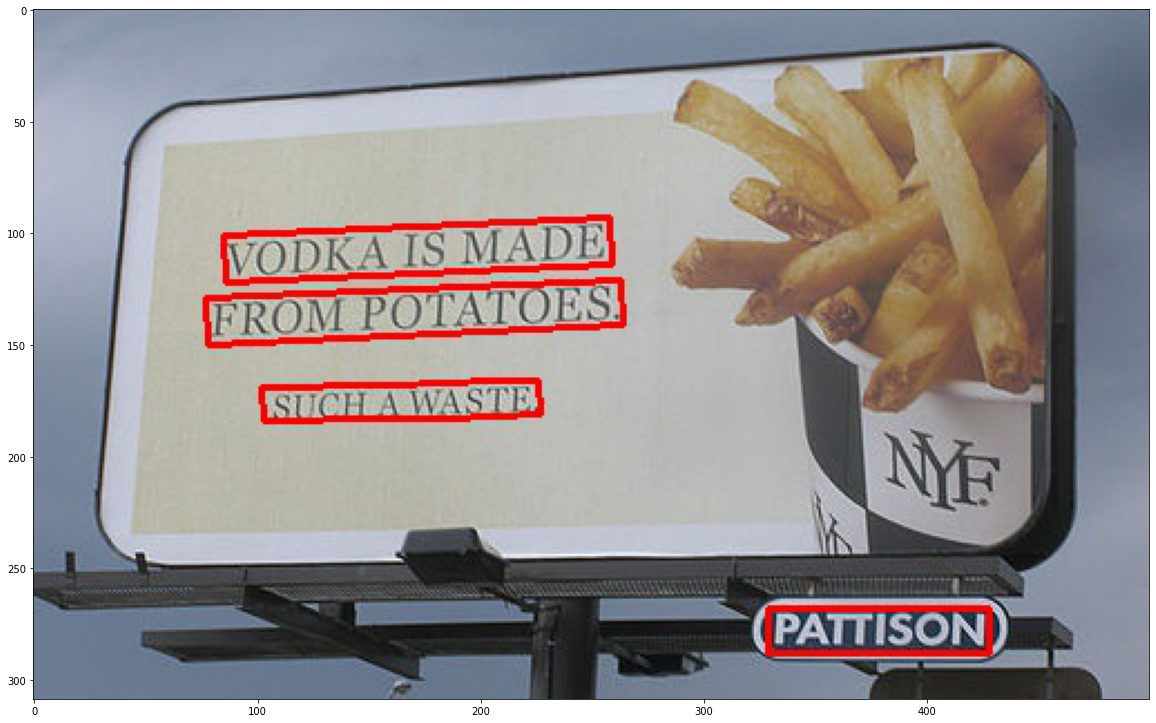

In [ ]:
plt.figure(figsize=(20, 26))
print(result_folder)
print(mask_file)
#print(image_path)
print(image_file_name)
plt.imshow(matplotlib.image.imread(join('/content', 'result','res_'+image_file_name)))
#print(image_file_name)
#/content/result

In [ ]:
    import cv2
    import numpy as np
    import tensorflow as tf
    #import efficientnet.tfkeras as efficientnet
    from tensorflow import keras

    #from . import tools
    import torch.nn as nn

    class CRAFT(nn.Module):
        def __init__(self, pretrained=False, freeze=False):
            super().__init__()
            # Base network
            self.basenet = vgg16_bn(pretrained, freeze)
            # U network
            self.upconv1 = double_conv(1024, 512, 256)
            self.upconv2 = double_conv(512, 256, 128)
            self.upconv3 = double_conv(256, 128, 64)
            self.upconv4 = double_conv(128, 64, 32)

            num_class = 2
            self.conv_cls = nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 16, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(16, 16, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(16, num_class, kernel_size=1),
            )

            init_weights(self.upconv1.modules())
            init_weights(self.upconv2.modules())
            init_weights(self.upconv3.modules())
            init_weights(self.upconv4.modules())
            init_weights(self.conv_cls.modules())

        def forward(self, x):  # pylint: disable=arguments-differ
            # Base network
            sources = self.basenet(x)
            # U network
            # pylint: disable=E1101
            y = torch.cat([sources[0], sources[1]], dim=1)

            y = self.upconv1(y)

            y = F.interpolate(y, size=sources[2].size()[2:], mode='bilinear', align_corners=False)
            y = torch.cat([y, sources[2]], dim=1)
            y = self.upconv2(y)

            y = F.interpolate(y, size=sources[3].size()[2:], mode='bilinear', align_corners=False)
            y = torch.cat([y, sources[3]], dim=1)
            y = self.upconv3(y)

            y = F.interpolate(y, size=sources[4].size()[2:], mode='bilinear', align_corners=False)
            y = torch.cat([y, sources[4]], dim=1)
            # pylint: enable=E1101
            feature = self.upconv4(y)

            y = self.conv_cls(feature)

            return y.permute(0, 2, 3, 1), feature

    def copyStateDict(state_dict):
        if list(state_dict.keys())[0].startswith("module"):
            start_idx = 1
        else:
            start_idx = 0
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = ".".join(k.split(".")[start_idx:])
            new_state_dict[name] = v
        return new_state_dict

    model = CRAFT(pretrained=True).eval()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
no_epochs = 5
batch_size = 4

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
#he training set contains 50,000 images, remaining 10,000 as testing set.
training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#Dataloader gets data into batches
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size,shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
criterion = nn.CrossEntropyLoss()   #already softmax is included
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

total_steps = len(training_loader)  #12500  (50,000/4)
for epoch in range(no_epochs):    #loop over epochs
    for i, (images, labels) in enumerate(training_loader):  #loop over batch,                                   
        # original shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        #images = images.to(device).cuda()
        #labels = labels.to(device).cuda()
        images = images.cuda()
        labels = labels.cuda()
        #print(device)

        # Forward pass
        #print(output)
        outputs,var = model(images) #predicted output
        #print(outputs)
        outputs=outputs.reshape(4,-1)
        #outputs = np.array(outputs)
        #outputs = torch.from_numpy(outputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  #empty the accumulated gradients first
        loss.backward()  #backprop with autograd
        optimizer.step()  #weight update

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{no_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')


Epoch [1/5], Step [2000/12500], Loss: 0.9336
Epoch [1/5], Step [4000/12500], Loss: 0.7914
Epoch [1/5], Step [6000/12500], Loss: 0.4521
Epoch [1/5], Step [8000/12500], Loss: 0.9116
Epoch [1/5], Step [10000/12500], Loss: 0.7776
Epoch [1/5], Step [12000/12500], Loss: 2.0417
Epoch [2/5], Step [2000/12500], Loss: 1.6231
Epoch [2/5], Step [4000/12500], Loss: 0.2948
Epoch [2/5], Step [6000/12500], Loss: 1.1679
Epoch [2/5], Step [8000/12500], Loss: 0.5884
Epoch [2/5], Step [10000/12500], Loss: 0.7143
Epoch [2/5], Step [12000/12500], Loss: 0.8093
Epoch [3/5], Step [2000/12500], Loss: 0.3087
Epoch [3/5], Step [4000/12500], Loss: 0.1598
Epoch [3/5], Step [6000/12500], Loss: 0.2871
Epoch [3/5], Step [8000/12500], Loss: 1.5478
Epoch [3/5], Step [10000/12500], Loss: 1.1502
Epoch [3/5], Step [12000/12500], Loss: 0.0241
Epoch [4/5], Step [2000/12500], Loss: 0.7130
Epoch [4/5], Step [4000/12500], Loss: 0.0726
Epoch [4/5], Step [6000/12500], Loss: 0.5043
Epoch [4/5], Step [8000/12500], Loss: 0.0793
Epoc

In [ ]:
image=loadImage('/content/images/billboard.jpg')
image=image
model(image)